In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn')
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

# Begin importing data

In [4]:
files = ["stage_2", "stage_3", "stage_4", "playoffs"]

df = pd.read_csv("data/phs_2018_stage_1.csv")
for f in files:
    df = df.append(pd.read_csv("data/phs_2018_" + f + ".csv"))

files.insert(0, "stage_1")
for f in files:
    df = df.append(pd.read_csv("data/phs_2019_" + f + ".csv").rename(columns={"pelstart_time":'start_time'}))
df = df.append(pd.read_csv('data/phs_2020_1.csv').rename(columns={"hero_name":'hero',"team_name":"team","player_name":"player","esports_match_id":"match_id","tournament_title":"stage"}))
df = df.append(pd.read_csv('data/phs_2020_2.csv').rename(columns={"hero_name":'hero',"team_name":"team","player_name":"player","esports_match_id":"match_id","tournament_title":"stage"}))
df = df.append(pd.read_csv('data/phs_2021_1.csv').rename(columns={"hero_name":'hero',"team_name":"team","player_name":"player","esports_match_id":"match_id","tournament_title":"stage"}))

In [5]:
map_df = pd.read_csv("data/match_map_stats.csv", index_col="match_id")

# Create some boolean masks

In [6]:
widow = df["hero"] == "Widowmaker"
mccree = df["hero"] == "McCree"
ashe = df["hero"] == "Ashe"
hanzo = df["hero"] == "Hanzo"
allHeros = df["hero"] == "All Heroes"
damageDone = df["stat_name"] == "All Damage Done"
timePlayed = df["stat_name"] == "Time Played"
weapAcc = df["stat_name"] == "Weapon Accuracy"
kills = df["stat_name"] == "Eliminations"

# Create win dataframe


In [7]:
match_win = map_df[['match_winner']]
match_win = match_win[~match_win.index.duplicated(keep='first')]
df_match = df.set_index('match_id')
df_match_player = df[allHeros & timePlayed].set_index('match_id')
df_win = pd.merge(df_match_player, match_win, left_index=True, right_index=True)
df_complete = pd.merge(df_match, match_win, left_index=True, right_index=True)   

In [8]:
def win_lose(x,y):
    if (x == y):
        return 'win'
    else:
        return 'lose'
        
df_win["match_result"] = df_win[["team","match_winner"]].apply(lambda x : win_lose(*x), axis=1)
df_complete["match_result"] = df_complete[["team","match_winner"]].apply(lambda x : win_lose(*x), axis=1)

In [9]:
df_win_subs = df_win
df_win_subs.reset_index(inplace=True)
df_win_subs = df_win_subs[['player','match_result','match_id']].drop_duplicates(keep=False)
df_subs_final = df_win_subs.set_index('player').drop_duplicates(keep='first')
df_subs_final['match_result'].value_counts()

win     319
lose    297
Name: match_result, dtype: int64

In [10]:
def heroType(x):
    if (x == "D.Va")|(x == "Winston")| (x == "Zarya")| (x == "Reinhardt")| (x == "Wrecking Ball")|( x == "Orisa")| (x =="Roadhog")|(x=="Sigma"):
        return "Tank"
    elif (x=="Zenyatta")| (x=="Lúcio")| (x == "Mercy")| (x == "Ana")| (x == "Brigitte")|(x == "Moira")|(x == "Baptiste"):
        return "Support"
    elif (x == "Tracer")| (x == "Widowmaker")| (x == "Sombra")| (x == "Genji")| (x == "Pharah")| (x == "Hanzo")|(x == "Junkrat")|(x == "Mei")|(x == "McCree")|(x == "Soldier: 76")|(x == "Doomfist")|(x == "Reaper")|(x == "Bastion")|(x == "Symmetra")|(x == "Torbjörn")|(x == "Ashe")|(x == "Echo"):
        return "Dps"
    else:
        return "none"
df["hero_type"] = df["hero"].apply(heroType)
##df_type = df[df["hero_type"] != "none"]

# Compute highest DPS hero

In [ ]:
herodps = []
hero = [widow, mccree, ashe, hanzo]
for n in hero:
    herodps.append(
        (df[damageDone & n]["stat_amount"].sum())
        / (df[timePlayed & n]["stat_amount"].sum())
    )
herodps

In [ ]:
ashe_c = df_complete["hero"] == "Ashe"
damageDone_c = df_complete["stat_name"] == "All Damage Done"
timePlayed_c = df_complete["stat_name"] == "Time Played"
shots_c = df_complete["stat_name"] == "Shots Fired"
damageTaken_c = df_complete["stat_name"] == "Damage Taken"
dynaDmg_c = df_complete["stat_name"] == "Damage - Dynamite"
ults_c =  df_complete["stat_name"] == "Ultimates Used"
objTime_c = df_complete["stat_name"] == "Objective Time"

In [ ]:
"Damage Taken","Shots Fired","Damage - Dynamite","Ultimates Used","Objective Time"

In [ ]:
df_ml_1 = pd.pivot_table(df_complete[ashe_c &(damageDone_c|timePlayed_c|shots_c|damageTaken_c|dynaDmg_c|ults_c|objTime_c)].reset_index(),values=('stat_amount'),
                    index=['match_id','player'],columns=['stat_name'], aggfunc=np.sum)
df_ml_2 = pd.pivot_table(df_complete[ashe_c &(damageDone_c|timePlayed_c|shots_c|damageTaken_c|dynaDmg_c|ults_c|objTime_c)].reset_index(),values='match_result',
                    index=['match_id','player'],columns=[], aggfunc='first')
df_ml = pd.concat([df_ml_1, df_ml_2], axis=1)
df_ml["Damage per Second"] = df_ml.apply(
        lambda x: x["All Damage Done"] / x["Time Played"], axis="columns")
df_ml["Shots per Second"] = df_ml.apply(
        lambda x: x["Shots Fired"] / (x["Time Played"]), axis="columns")
df_ml["Damage Recieved per Second"] = df_ml.apply(
        lambda x: x["Damage Taken"] / (x["Time Played"]), axis="columns")
df_ml["Ultimates per Second"] = df_ml.apply(
        lambda x: x["Ultimates Used"] / (x["Time Played"]), axis="columns")
df_ml["Dynamite Damage per Second"] = df_ml.apply(
        lambda x: x["Damage - Dynamite"] / (x["Time Played"]), axis="columns")
df_ml["Objective Time per Second"] = df_ml.apply(
        lambda x: x["Objective Time"] / (x["Time Played"]), axis="columns")
df_ml = df_ml[(df_ml['Time Played'] >= 60)&(df_ml['All Damage Done'] >= 0.1)]
df_ml = df_ml.drop(['All Damage Done', 'Time Played',"Damage Taken","Shots Fired","Damage - Dynamite","Ultimates Used","Objective Time"], axis=1).fillna(0)

In [ ]:
def win_to_number(x):
    if x == "win":
        return 1
    elif x=="lose":
        return 0
    else:
        return "none"
df_ml["match_result"] = df_ml["match_result"].apply(win_to_number)
df_ml

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(df_ml.drop("match_result", axis=1))
df_scaled= pd.DataFrame(X, columns=df_ml.drop("match_result", axis=1).columns, index=df_ml.index)
df_scaled["match_result"] = df_ml["match_result"]

In [ ]:
corr_matrix = df_scaled.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [ ]:
df_ml_train = df_scaled.sample(frac=0.75)
df_ml_test = df_scaled.append(df_ml_train)
df_ml_test = df_ml_test.drop_duplicates(keep=False)

In [126]:
x_train = df_ml_train.drop("match_result", axis=1)
y_train = df_ml_train['match_result']
x_test = df_ml_test.drop("match_result", axis=1)
y_test = df_ml_test['match_result']

In [ ]:
df_ml_train

In [117]:
model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
'n_estimators':[100,250,500,750,1000,1250,1500,1750],
'max_depth':[2,3,4,5,6,7],
'min_samples_split':[2,4,6,8,10,20,40,60,100],
'min_samples_leaf':[1,3,5],
'max_features':[2,3,4],
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]} 

In [119]:
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.7, 'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 5, 'learning_rate': 0.05}
Best Model mean accuracy: 0.6121951219512195


In [120]:

random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=100, 
       scoring="accuracy").fit(x_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_


Best Model parameters: {'subsample': 0.75, 'n_estimators': 1250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': 3, 'learning_rate': 0.005}
Best Model mean accuracy: 0.624390243902439


In [123]:
model.fit(x_train, y_train)
## test
predicted_prob = model.predict_proba(x_test)[:,1]
predicted = model.predict(x_test)

In [127]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))


Accuracy (overall correct predictions): 0.56
Auc: 0.59


In [ ]:
df_hitscan = pd.pivot_table(df[(widow | mccree | ashe | hanzo)&(damageDone|timePlayed)],values='stat_amount',
                    index=['map_name', 'hero'],columns=['stat_name'], aggfunc=np.sum)
df_hitscan["Damage per Second"] = df_hitscan.apply(
        lambda x: x["All Damage Done"] / x["Time Played"], axis="columns")
df_hitscan.to_csv(r'data/hitscan_data.csv')

In [ ]:
sns.set_style("dark")
sns.barplot(x="Damage per Second", y="map_name", hue="hero", data=df_hitscan.reset_index(), orient="h").set(ylabel='Map')
plt.legend(title="Hero:",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
support = df["hero_type"] == "Support"
heals = df["stat_name"] == "Healing Done"

In [ ]:
df_heals = pd.pivot_table(df[support&(heals|timePlayed)],values='stat_amount',
                    index=['map_name', 'hero'],columns=['stat_name'], aggfunc=np.sum)
df_heals["Healing per Second"] = df_heals.apply(
        lambda x: x["Healing Done"] / x["Time Played"], axis="columns")
df_heals.to_csv(r'data/heals_data.csv')

In [ ]:
(100.7, 30.27)
plt.subplots(figsize=a4_dims)
sns.set_style("dark")
sns.barplot(x="Healing per Second", y="map_name", hue="hero", data=df_heals.reset_index(), orient="h").set(ylabel='Map')
plt.legend(title="Hero:",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Ashe has greatest dps



# FIX THiS LATER 

In [15]:
df_type = df[df["hero_type"] != "none"]

In [19]:
sr_kills = df[kills]["stat_amount"]
sr_kills.name = "Eliminations"
sr_wpacc = df[weapAcc]["stat_amount"]
sr_wpacc.name = "Weapon Accuracy"
sr_type = df_type["hero_type"]
sr_type.name = "Hero Type"
sr_dmg = df[damageDone]["stat_amount"]
sr_dmg.name = "Damage Done"

In [20]:
df_kill_wpacc = pd.merge(sr_kills, sr_wpacc, left_index=True, right_index=True)
df_type_kill_wpacc = pd.merge(df_kill_wpacc, sr_type, left_index=True, right_index=True)
df_dmg_wpacc = pd.merge(sr_dmg, sr_wpacc, left_index=True, right_index=True)
df_type_dmg_wpacc = pd.merge(df_dmg_wpacc, sr_type, left_index=True, right_index=True)
df_dmg_kill = pd.merge(sr_dmg, sr_kills, left_index=True, right_index=True)
df_type_dmg_kill = pd.merge(df_dmg_kill, sr_type, left_index=True, right_index=True)

<AxesSubplot:xlabel='Eliminations', ylabel='Weapon Accuracy'>

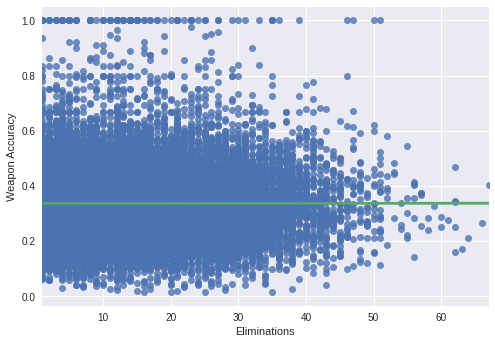

In [21]:
sns.regplot(x="Eliminations", y="Weapon Accuracy", data=df_kill_wpacc, line_kws={"color": "C1"})

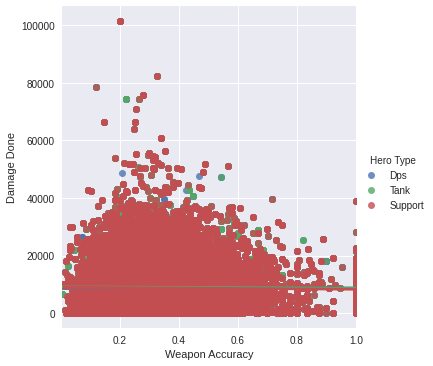

In [26]:
sns.lmplot( data=df_type_dmg_wpacc,
    x="Weapon Accuracy", y="Damage Done", hue="Hero Type",
    height=5)

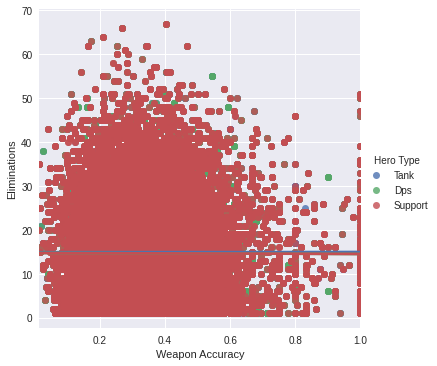

In [29]:
sns.lmplot( data=df_type_kill_wpacc,
    x="Weapon Accuracy", y="Eliminations", hue="Hero Type",
    height=5)

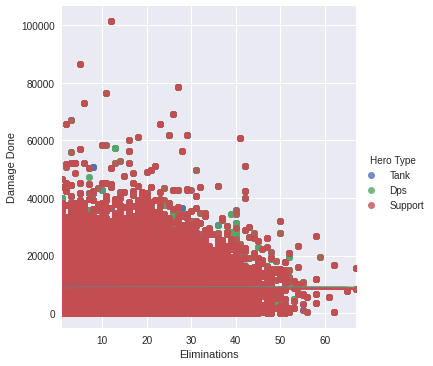

In [30]:
sns.lmplot( data=df_type_dmg_kill,
    x="Eliminations", y="Damage Done", hue="Hero Type",
    height=5)

In [25]:
df_type_dmg_kill.head(20)

,Damage Done,Eliminations,Hero Type
82,11198.28463,18.0,Tank
82,11198.28463,18.0,Dps
82,11198.28463,18.0,Support
82,11198.28463,18.0,Tank
82,11198.28463,18.0,Tank
82,11198.28463,18.0,Dps
82,11198.28463,7.0,Tank
82,11198.28463,7.0,Dps
82,11198.28463,7.0,Support
82,11198.28463,7.0,Tank


No difference in correlation between kills, elims, and weapon accuracy between hero types

In [26]:
asheStats = df[ashe]

In [27]:
_prim = df["stat_name"] == "Damage - Weapon"
_sec = df["stat_name"] == "Damage - Weapon Scoped"
_time = df["stat_name"] == "Time Played"
_dmg = df["stat_name"] == "All Damage Done"
df_ashe_stats = df[(_prim | _sec | _time | _dmg) & ashe]#["stat_amount"]
# prim_dmg = df[prim]['stat_amount'].astype(float)
# prim_dmg.name = 'Primary Damage'
# sec_dmg = asheStats[sec]['stat_amount'].astype(float)
# sec_dmg.name = 'Secondary Damage'
# test = pd.merge(prim_dmg,sec_dmg, left_index=True, right_index=True)
# test
#Cant use asheStats?
#pd.pivot_table(df_ashe_stats, index="player", columns="stat_name", values="stat_amount")
_idx_cols = df_ashe_stats.columns.drop(["stat_name", "stat_amount"])
_cols = "stat_name"
_values = "stat_amount"
df_ashe_stats = pd.pivot(df_ashe_stats, index=_idx_cols, columns=_cols, values=_values).reset_index()

In [28]:
_cols_to_fill = ["All Damage Done", "Damage - Weapon", "Damage - Weapon Scoped"]
df_ashe_stats[_cols_to_fill] = df_ashe_stats[_cols_to_fill].fillna(0)

In [29]:
# compute normalized damage amounts (normalized to time)
for i in _cols_to_fill:
    df_ashe_stats[i + "_normalized"] = df_ashe_stats.apply(
        lambda x: x[i] / x["Time Played"], axis="columns"
    )

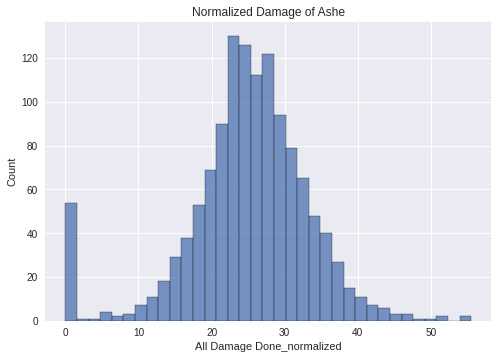

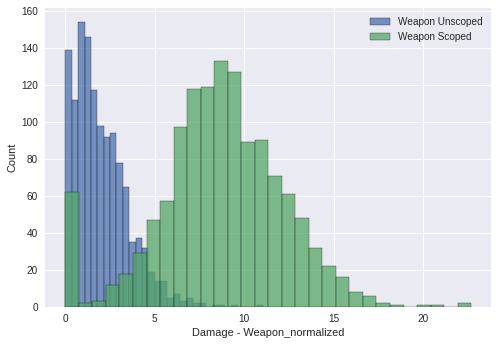

In [30]:
# set plots
sns.histplot(df_ashe_stats, x="All Damage Done_normalized")
plt.title("Normalized Damage of Ashe")

plt.figure()
sns.histplot(df_ashe_stats, x="Damage - Weapon_normalized", label="Weapon Unscoped")
sns.histplot(df_ashe_stats, x="Damage - Weapon Scoped_normalized", color="C1", label="Weapon Scoped")
plt.legend()

In [ ]:
#asheSecondary = (asheStats['stat_name'] == 'Secondary Fire Accuracy')
#for i in range(52660):
   # if (asheStats['stat_name'].iloc[i] == 'Secondary Fire Accuracy'):
       # asheStats['stat_name'].iloc[i] = "Scoped Accuracy"
        #shows an error but works for some reason
        #Also I have no idea why I even made this in the first place


This is a work in progress